# Comparing the Convergence of various Policy gradient algorithms

In [1]:
!pip install pymdptoolbox   #Install pymdptoolbox within the code

## Import libraries

In [1]:
import mdptoolbox.example
import numpy as np
import sys
import time
import warnings
import matplotlib.pyplot as plt
from cvxopt import matrix, solvers
import os
import seaborn as sns
sns.set()
warnings.filterwarnings('ignore')

In [2]:
class HiddenPrints:       #To suppress print statements during execution of library function
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout

## Class MDP

In [40]:
'''
Class MarkovDP contains the following attributes:
1)Number of states  : s
2)Number of actions : a
3)State Space
4)Action Space
5)Transition probability matrix of size (a,s,s)
6)Reward matrix (a,s,s)
'''
class MarkovDP:
    def __init__(self,s,a):
        self.num_state             = s
        self.num_action            = a
        self.states                = np.array(range(0,s))
        self.actions               = np.array(range(0,a))
        self.transitions           = np.zeros((a,s,s))
        self.rewards               = np.zeros((a,s,s))
        
# The function below initializes transition probability matrix and rewards marks 

    def initialize_mdp(self):      
        np.random.seed(0)        #for reproducibility 
        self.transitions, self.rewards = mdptoolbox.example.rand(self.num_state,self.num_action)
        self.rewards = np.random.rand(self.num_action,self.num_state,self.num_state)

## Utility Functions

In [65]:
def softmax(env,theta,phi):
    pi = np.zeros((env.num_state,env.num_action),dtype=float)
    for s in env.states:
        for a in env.actions:
            pi[s][a]=np.exp(np.dot(np.array(phi[s][a]),theta))
        pi[s]=pi[s]/np.sum(pi[s])
    return np.array(pi)

def P_matrix(env,pi):
    # Compute Transition probabilities P(s,s') using P(s'| s,a ) and pi( a|s ) : Matrix of size |s| x |s|
    P=np.empty((env.num_state,env.num_state),dtype=float)
    P=np.multiply(np.reshape(pi[:,0],(-1,1)),env.transitions[0][:][:])
    for a in range(1,env.num_action):
        P=P+np.multiply(np.reshape(pi[:,a],(-1,1)),env.transitions[a][:][:])
    return P
        
def d_pi_s(env,P,gamma,s):
    e_s=np.zeros((env.num_state,1))
    e_s[s]=1
    i= np.identity(env.num_state)- gamma*(P)
    d= (1-gamma) * np.dot(np.linalg.inv(i),e_s)
    return d

def softmax_normal(env,pi_theta):
    pi = np.zeros((env.num_state,env.num_action),dtype=float)
    for s in env.states:
        pi[s]=np.exp(pi_theta[s])
        pi[s]=pi[s]/np.sum(pi[s])
    return np.array(pi)

In [42]:
# Policy Evaluation Function
def evaluate_policy(env, pi, gamma, theta):
    V = np.zeros((env.num_state,1))
    while True:
        delta = 0
        for s in env.states:
            v = V[s].copy()
            V=update_v_policy(env, V, pi, s, gamma)    #bellman update 
            delta = max(delta, abs(v - V[s]))
        if delta < theta:
            break
    return V


# Bellman Update function
def update_v_policy(env, V, pi, s, gamma):
    sum=0
    for a in env.actions:
        transitions = np.reshape(env.transitions[a][s][:],(-1,1))
        rewards = np.reshape(env.rewards[a][s][:],(-1,1))
        sum=sum+pi[s][a]*(np.sum(np.multiply(transitions,(rewards+(gamma*V)))))
    V[s]=sum
    return V

# Function that chooses the greedy action for a particular state 's'
def choose_best_action(env, V, pi, s, gamma):
    q=np.empty((env.num_action,1),dtype=float)
    for a in env.actions:
        pi[s][a]=0
        transitions = np.reshape(env.transitions[a][s][:],(-1,1))
        rewards = np.reshape(env.rewards[a][s][:],(-1,1))
        q[a]=np.sum(np.multiply(transitions,rewards)+ gamma * np.multiply(transitions,V))
    action=np.argmax(q)        #Choose greedy action
    pi[s][action]=1            #Update Policy


#Policy Improvement step
def improve_policy(env, V, pi, gamma):
    policy_stable = True        # If policy_stable == True : Policy need not be updated anymore
    for s in env.states:
        old = pi[s].copy()
        choose_best_action(env, V, pi, s, gamma)
        if not np.array_equal(pi[s], old): 
            policy_stable = False
    return pi, policy_stable

#Policy Iteration
def policy_iteration(env, gamma, theta):
    V = np.zeros((env.num_state,1))          #Initialize Value function vector : [0,0,0...0]
    pi = np.ones((env.num_state,env.num_action)) / env.num_action   #Policy Initialization
    policy_stable = False
    while not policy_stable:
        V = evaluate_policy(env, pi, gamma, theta)          #Policy Evaluation step
        pi, policy_stable = improve_policy(env, V, pi, gamma)  #Policy Iteration step
    return V, pi

In [43]:
def evaluate_q(env, pi, gamma, V):
    Q = np.zeros((env.num_state,env.num_action))
    for s in env.states:
        for a in env.actions:
            transitions = np.reshape(env.transitions[a][s][:],(-1,1))
            rewards = np.reshape(env.rewards[a][s][:],(-1,1))
            Q[s][a] = np.sum(np.multiply(transitions,rewards)+ gamma * np.multiply(transitions,V))
    return Q

In [44]:
def phi_tilde(env,pi,phi,s):
    phi_s=np.zeros(d)  #np.zeros replacee
    for a in env.actions:
        phi_s = phi_s+phi[s][a]*pi[s][a]
    #print(phi_s)
    return phi_s
    

In [45]:
def policy(s,a):
    pi = np.ones((s,a)) / a   #Policy Initialization
    return pi   

In [46]:
def projection(env,x):
    P = 2*matrix(np.identity(env.num_action))
    q = -2*matrix(x)
    G = -1*matrix(np.identity(env.num_action))
    h = matrix(np.zeros(env.num_action))
    A = matrix(np.ones(env.num_action), (1,env.num_action))
    b = matrix(1.0)
    with HiddenPrints():
        sol=solvers.qp(P, q, G, h, A, b)
    proj= np.reshape(np.array(sol['x']),(1,-1))
    return proj


## Direct param

In [47]:
def grad(env,gamma,rho,pi,theta):
    V_grad= np.empty((env.num_state,env.num_action),dtype=float)
    P=P_matrix(env,pi)
    V=evaluate_policy(env, pi, gamma, theta)
    for s in env.states:
        d=d_pi_s(env,P,gamma,s)
        d_rho= np.dot(rho,d)
        for a in env.actions:
            transitions = np.reshape(env.transitions[a][s][:],(-1,1))
            rewards = np.reshape(env.rewards[a][s][:],(-1,1))
            q=np.sum(np.multiply(transitions,rewards)+ gamma * np.multiply(transitions,V))
            V_grad[s][a]= (d_rho*q)/(1-gamma)
    
    return V_grad
            
        

In [48]:
def policy_gradient(env,gamma,EPS,rho,iterations,learning_rate,V_rho_optimal):
    pi = np.ones((env.num_state,env.num_action)) / env.num_action   #Policy Initialization
    V = np.zeros((env.num_state,1))          #Initialize Value function vector : [0,0,0...0]
    min_t = V_rho_optimal
    min_list=list()
    history =list()
    for i in range(0,iterations):
        V_grad=grad(env,gamma,rho,pi,theta)
        for s in env.states:
            pi_update= pi[s]+ learning_rate * V_grad[s]
            pi[s]= projection(env,pi_update) 
        V=evaluate_policy(env, pi, gamma, EPS) 
        history.append(np.dot(rho,V)[0])
        min_t=min(min_t,(V_rho_optimal-np.dot(rho,V)[0]))
        min_list.append(min_t)
    return min_list,history
        

## Softmax param

In [115]:
def grad_softmax(env,gamma,rho,pi_theta,theta):
    V_grad = np.zeros((env.num_state,env.num_action))
    pi = softmax_normal(env,pi_theta)
    #print(pi)
    P = P_matrix(env,pi)
    V = evaluate_policy(env, pi, gamma, theta)
    #print(V_grad[0][1])
    for s in range(0,env.num_state):
        d=d_pi_s(env,P,gamma,s)
        d_rho= np.dot(rho,d)
        for a in range(0,env.num_action):
            transitions = np.reshape(env.transitions[a][s][:],(-1,1))
            rewards = np.reshape(env.rewards[a][s][:],(-1,1))
            q=np.sum(np.multiply(transitions,rewards)+ gamma * np.multiply(transitions,V))
            advantage=q-V[s]
            V_grad[s][a]= (d_rho*advantage*pi[s][a])/(1-gamma)
    
    
    return V_grad
            
        

In [116]:
def policy_gradient_constant_step(env,gamma,EPS,rho,iterations,learning_rate,V_rho_optimal):
    pi_theta = np.ones((env.num_state,env.num_action)) / env.num_action   #Policy Initialization
    V = np.zeros((env.num_state,1))          #Initialize Value function vector : [0,0,0...0]
    min_t = V_rho_optimal
    min_list=list()
    history = list()
    for i in range(0,iterations):
        V_grad=grad_softmax(env,gamma,rho,pi_theta,EPS)
        for s in env.states:
            pi_theta[s]= pi_theta[s]+ learning_rate * V_grad[s]
        pi = softmax_normal(env,pi_theta)
        V=evaluate_policy(env, pi, gamma, EPS)
        #print(V_grad)
        history.append(np.dot(rho,V)[0])
        min_t=min(min_t,(V_rho_optimal-np.dot(rho,V)[0]))
        min_list.append(min_t)
    return min_list,history
        

## NPG Softmax

In [95]:
def softmax_npg(env,gamma,EPS,rho,iterations,V_rho_optimal,step_size):
    start_time = time.time()
    pi = np.ones((env.num_state,env.num_action)) / env.num_action
    min_t = V_rho_optimal
    min_list=list()
    history = list()
    learning_rate = 1
    for i in range(0,iterations):
        V = evaluate_policy(env, pi, gamma, EPS)
        Q = evaluate_q(env, pi, gamma, V)
        A = Q-V
        X=np.empty((env.num_state,env.num_action),dtype=float)
        for s in env.states:
            for a in env.actions:
                X[s][a]= np.exp(step_size*A[s][a]/(1-gamma))
            X[s]=X[s]/np.sum(np.multiply(X[s],pi[s]))
        pi=np.multiply(pi,X)
        V=evaluate_policy(env, pi, gamma, EPS)
        history.append(V)
        min_t=min(min_t,(V_rho_optimal-np.dot(rho,V)[0]))
        min_list.append(min_t)
    
    return min_list,history
 

## Policy grad with function approx

In [52]:
def policygradient_funapprox(env,gamma,phi,step_size,iterations,d,EPS,rho,V_rho_optimal):
    theta = np.zeros((d,1))
    w  = np.zeros((d,1))
    min_t = V_rho_optimal
    min_list=list()
    history = list()
    for i in range(0,iterations):
        pi = softmax(env,theta,phi)
        #print(pi)
        P = P_matrix(env,pi)
        V = evaluate_policy(env, pi, gamma, EPS)
        Q_pi = evaluate_q(env, pi, gamma, V)
        d_rho = np.zeros((env.num_state,1))
        for s in env.states:
            d_s = d_pi_s(env,P,gamma,s)
            d_rho = d_rho+ rho[s]*d_s 
    
        b= np.zeros((d,1))
        A= np.zeros((d,d))
        theta_u = np.zeros((d,1))
        for s in env.states:
            phi_tilde_s = phi_tilde(env,pi,phi,s)
            for a in env.actions:
                phi_t = (phi[s][a]-phi_tilde_s)
                #print(np.dot(phi_t,np.transpose(w)[0]))
                dfw = phi_t * pi[s][a]
                theta_u = theta_u + d_rho[s]* np.reshape(dfw,(d,1)) * np.dot(phi_t,np.transpose(w)[0])
                b = b + d_rho[s]* np.reshape(dfw,(d,1)) * Q_pi[s][a]
                x = d_rho[s] * dfw
                for j in range(0,d):
                    #print(j)
                    A[j] = A[j] + x*phi_t[j]
        #print(A)
        #print(b)
        w = np.dot(np.linalg.inv(A),b)
        #print(w)
        theta = theta +  step_size*theta_u
        V=evaluate_policy(env, pi, gamma, EPS)
        history.append(np.dot(rho,V)[0])
        min_t=min(min_t,(V_rho_optimal-np.dot(rho,V)[0]))
        min_list.append(min_t)
        #print(theta)
    return min_list,history
   

## NPG function approx


In [53]:
def argmin_wt(Q,p,d):
    Q = 2*matrix(Q)
    p = matrix(p)
    with HiddenPrints():
        sol=solvers.qp(Q,p)
    wt= np.array(sol['x'])
    return wt


In [74]:
def npg_funapprox(env,gamma,phi,EPS,rho,step_size,iterations,d,V_rho_optimal):
    theta = np.zeros((d,1))
    min_t = V_rho_optimal
    min_list=list()
    history=list()
    for i in range(0,iterations):
        pi = softmax(env,theta,phi)
        P = P_matrix(env,pi)
        V = evaluate_policy(env, pi, gamma, EPS)
        Q_pi = evaluate_q(env, pi, gamma, V)
        A = Q_pi-V
        Q = np.zeros((d,d))
        p = np.zeros(d)
        #print(p)
        d_rho = np.zeros((env.num_state,1))
        for s in env.states:
            d_s = d_pi_s(env,P,gamma,s)
            d_rho = d_rho+ rho[s]*d_s
        for s in env.states:
            phi_tilde_s = phi_tilde(env,pi,phi,s)
            for a in env.actions:
                phi_t = (phi[s][a]-phi_tilde_s)
                phi_t = np.reshape(phi_t,(1,d))
                phi_t_t = np.reshape(phi_t,(d,1))
                Q = Q+ (d_rho[s]*pi[s][a]*np.dot(phi_t_t,phi_t))
                phi_t = (phi[s][a]-phi_tilde_s)
                p = p+ (-2*A[s][a]*d_rho[s][0]*pi[s][a]*phi_t)
        wt = argmin_wt(Q,p,d)
        #print(A)
        theta = theta + step_size*wt
        V=evaluate_policy(env, pi, gamma, EPS) 
        history.append(np.dot(rho,V)[0])
        min_t=min(min_t,(V_rho_optimal-np.dot(rho,V)[0]))
        min_list.append(min_t)
        #print(softmax(env,theta,phi))
    return min_list,history 

## Plot

In [120]:
def plot_log(min_list1,min_list2,min_list3,min_list4,min_list5,iterations):
    
    x=np.log(np.array(range(0,iterations))+1)
    y1=np.log(np.array(min_list1)[:])
    y2=np.log(np.array(min_list2)[:])
    y3=np.log(np.array(min_list3)[:])
    y4=np.log(np.array(min_list4)[:])
    y5=np.log(np.array(min_list5)[:])
    plt.tick_params(axis='y',labelsize=9)
    plt.tick_params(axis='x',labelsize=9)
    plt.xlabel('log(t)', fontsize=12)
    plt.ylabel('log(min(V_opt-V(t)))', fontsize=12)
    plt.plot(x,y1, label='Direct param ') 
    plt.plot(x,y2, label='Soft param') 
    plt.plot(x,y3, label='npg softparam') 
    plt.plot(x,y4, label='function approx') 
    plt.plot(x,y5, label='npg function approx') 
    plt.title('50x2 mdp, step size=0.3,dim(phi=10)',fontsize=12)
    fig_size=(10,7)
    plt.rcParams["figure.figsize"] = fig_size
    plt.legend(loc='best') 
    plt.show()

In [56]:
'''
Define an MDP Environment : Insantiate Class
    Number of states : s
    Number of actions : a
'''

s=50
a=2
d=10
env= MarkovDP(s,a)      #Define an MDP Environment : Insantiate Class
np.random.seed(0)
env.initialize_mdp()    #Define P and R
phi = np.random.rand(env.num_state,env.num_action,d) #d=2

In [57]:
gamma = 0.9       #Discount rate
EPS = 0.0001    #A small positive number
rho= np.ones(env.num_state)/env.num_state
start_time = time.time()
V_optimal_policy,pi_optimal_policy=policy_iteration(env, gamma, EPS)
print("--- %s seconds ---" % (time.time() - start_time))

--- 0.33742332458496094 seconds ---


In [58]:
V_rho_optimal = np.dot(rho,V_optimal_policy)[0]

In [59]:
V_rho_optimal

5.228624210968419

In [61]:
learning_rate = 0.3
iterations =1000

min_list1,history1=policy_gradient(env,gamma,EPS,rho,iterations,learning_rate,V_rho_optimal)

In [117]:
learning_rate = 0.3
iterations =1000

min_list2,history2=policy_gradient_constant_step(env,gamma,EPS,rho,iterations,learning_rate,V_rho_optimal)

In [71]:
learning_rate = 0.3
iterations =1000

min_list3,history3=softmax_npg(env,gamma,EPS,rho,iterations,V_rho_optimal,learning_rate)

In [72]:
learning_rate = 0.3
iterations =1000

min_list4,history4=policygradient_funapprox(env,gamma,phi,learning_rate,iterations,d,EPS,rho,V_rho_optimal)

In [77]:
learning_rate = 0.3
iterations =1000

min_list5,history5=npg_funapprox(env,gamma,phi,EPS,rho,learning_rate,iterations,d,V_rho_optimal)

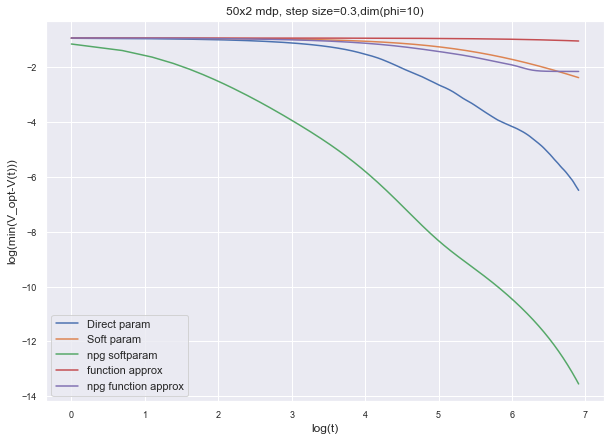

In [121]:
plot_log(min_list1,min_list2,min_list3,min_list4,min_list5,iterations)

In [122]:
def plot_history(history1,history2,history3,history4,history5,iterations):
    
    x=(np.array(range(0,iterations))+1)
    y1=(np.array(history1)[:])
    y2=(np.array(history2)[:])
    y3=(np.array(history3)[:])
    y4=(np.array(history4)[:])
    y5=(np.array(history5)[:])
    plt.tick_params(axis='y',labelsize=9)
    plt.tick_params(axis='x',labelsize=9)
    plt.xlabel('iterations', fontsize=12)
    plt.ylabel('V(rho)', fontsize=12)
    plt.plot(x,y1, label='Direct param ') 
    plt.plot(x,y2, label='Soft param') 
    plt.plot(x,y3, label='npg softparam') 
    plt.plot(x,y4, label='function approx') 
    plt.plot(x,y5, label='npg function approx') 
    plt.title('50x2 mdp, step size=0.3,dim(phi=10)',fontsize=12)
    fig_size=(10,7)
    plt.rcParams["figure.figsize"] = fig_size
    plt.legend(loc='best') 
    plt.show()

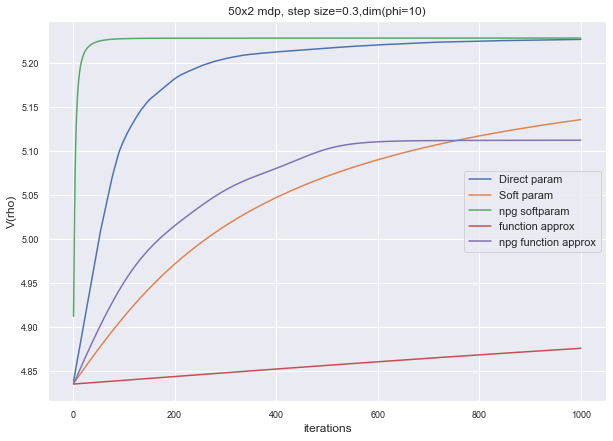

In [123]:
plot_history(history1,history2,history3,history4,history5,iterations)

## Observation

- Among all the algorithms studied in this notebook, Natural Policy gradient performs the best. It has the fastest rate of convergence compared to the rest, and also converges to the most accurate value function </br>
- There is a significant improvement in the convergence if natural policy gradients are used instead of corresponding vanilla gradients